In [38]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### Generating the Dataset


(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

The noise term $\epsilon$ obeys a normal distribution
with a mean of 0 and a standard deviation of 0.1.
For optimization, we typically want to avoid
very large values of gradients or losses.
This is why the *features*
are rescaled from $x^i$ to $\frac{x^i}{i!}$.
It allows us to avoid very large values for large exponents $i$.
We will synthesize 100 samples each for the training set and test set.


In [39]:
max_degree = 20 
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)  # create a (1, 20) matrix
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # give 4 values in the first four cols

features = np.random.normal(size=(n_train + n_test, 1))  # create a (200, 1) matrix
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) 
                # np.power(a,b) = a^b (element by element through broadcasting)

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)  # scale = variance; loc = average

In [40]:
# np.power(a,b) = a^b (element by element through broadcasting)
# For testing
A = np.array([[1.0], [2.0], [3.0], [5.0], [8.0], [9.0]])
B = np.array([2.0, 3.0])
C = np.power(A, B)
print(A)
print(C)

[[1.]
 [2.]
 [3.]
 [5.]
 [8.]
 [9.]]
[[  1.   1.]
 [  4.   8.]
 [  9.  27.]
 [ 25. 125.]
 [ 64. 512.]
 [ 81. 729.]]


In [41]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]
                ]

In [42]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.7625],
         [-0.3874]]),
 tensor([[ 1.0000e+00,  7.6249e-01,  2.9070e-01,  7.3885e-02,  1.4084e-02,
           2.1478e-03,  2.7295e-04,  2.9732e-05,  2.8338e-06,  2.4008e-07,
           1.8306e-08,  1.2689e-09,  8.0630e-11,  4.7292e-12,  2.5757e-13,
           1.3093e-14,  6.2396e-16,  2.7986e-17,  1.1855e-18,  4.7576e-20],
         [ 1.0000e+00, -3.8738e-01,  7.5032e-02, -9.6887e-03,  9.3830e-04,
          -7.2696e-05,  4.6935e-06, -2.5974e-07,  1.2577e-08, -5.4136e-10,
           2.0971e-11, -7.3853e-13,  2.3841e-14, -7.1043e-16,  1.9658e-17,
          -5.0767e-19,  1.2291e-20, -2.8009e-22,  6.0278e-24, -1.2290e-25]]),
 tensor([5.1929, 4.1418]))

In [43]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)   # get the loss between network output and y
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [44]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()  # define loss is MSEloss
    input_shape = train_features.shape[-1]
    
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # define a simple one-layer linear regression network
    batch_size = min(10, train_labels.shape[0])
    
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('Weight:', net[0].weight.data.numpy())

Weight: [[ 4.968895   1.2087787 -3.3687868  5.5112834]]


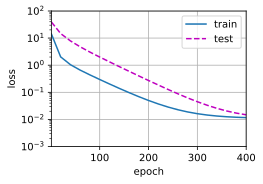

In [45]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

Weight: [[3.912084  2.5719917]]


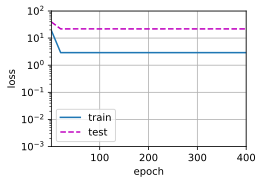

In [46]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])
# underfitting: do not decrease

Weight: [[ 4.9456182e+00  1.2467588e+00 -3.2169316e+00  5.1387882e+00
  -4.7328851e-01  1.5900165e+00 -2.0759159e-01  3.4184542e-01
  -2.6846249e-02  3.9945688e-02  2.1472314e-01 -1.7353088e-01
   2.0338650e-01 -9.0815440e-02 -3.9672623e-03 -8.2379915e-02
  -1.4729483e-01 -1.9771850e-01 -3.1574517e-03  2.2014531e-01]]


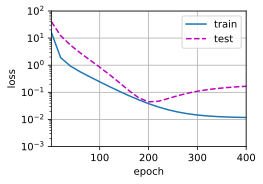

In [47]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])
# overfitting: learn all noise into it